#### CIE-Project B || Group - 7

#### Imports

In [456]:
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy.signal import resample, find_peaks
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pickle
import time

# from sklearn import preprocessing ##importing for normalization
# from sklearn.decomposition import PCA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler, minmax_scale, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, AveragePooling1D
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.frameon'] = True
# plt.rcParams['figure.figsize'] = (8, 8)
%matplotlib widget

tf.random.set_seed(1)
np.random.seed(2)

##### Get the root directory and change to it

In [457]:
rootdir = os.getcwd()
os.chdir(rootdir)

#### Folder Variables Assignment

In [458]:
# Names of the folders
Training_Folder = 'EPOT_DATA'
Validation_Aug_Folder = 'Validation_augmented_data'
Experiment = 'Experiment_Data_Group7'
Ex_Validation = 'Experimental_validation'

counter = 0

#### Parsing

##### Parse training and validation-augmented data

In [459]:
# Initialize lists for training and validation
training_tr = []; training_tr_labels = []

validation_aug = []; validation_aug_labels = [] # validation augmented data

#------------------------------------------------------------------------------

for subdir, dirs, files in os.walk(rootdir):
    
    if Training_Folder.lower() in subdir.lower():
        for file in files:
            if file.endswith('.mat'):
                lbl = [file.split('_')[1], file.split('_')[2][:3]]
                lb = np.asarray(lbl, dtype=float)
                # load mat-file
                mat = loadmat(os.path.join(subdir, file))
                # get the numpy data from the mat file
                mat = mat['num_data']
                # append data to the list
                training_tr.append(mat)
                training_tr_labels.append(lb)

    elif Validation_Aug_Folder.lower() in subdir.lower():
        for file in files:
            if file.endswith('.mat'):
                lbl = [file.split('_')[1], file.split('_')[2][:3]]
                lb = np.asarray(lbl, dtype=float)
                # load mat-file
                mat = loadmat(os.path.join(subdir, file))
                # get the numpy data from the mat file
                mat = mat['num_data']
                # append data to the list
                validation_aug.append(mat)
                validation_aug_labels.append(lb)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
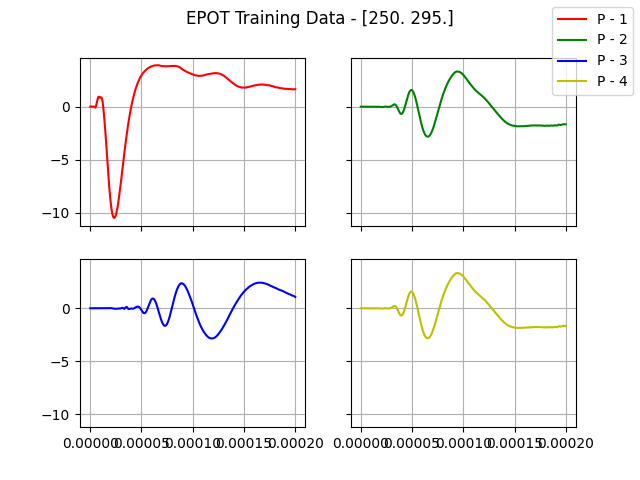

In [460]:
plt.close()
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

l = 6

fig.suptitle(f'EPOT Training Data - {training_tr_labels[l]}')

axs[0,0].plot(training_tr[l][:,0], training_tr[l][:,1], label='P - 1', c = 'r')
axs[0,1].plot(training_tr[l][:,0], training_tr[l][:,2], label='P - 2', c = 'g')
axs[1,0].plot(training_tr[l][:,0], training_tr[l][:,3], label='P - 3', c = 'b')
axs[1,1].plot(training_tr[l][:,0], training_tr[l][:,4], label='P - 4', c = 'y')

fig.legend()
plt.show()

##### Parse, Cut, Normalize, and Resample the experimental data

In [461]:
# Initialize lists for training and validation
ex_data = []; ex_labels = []

#------------------------------------------------------------------------------

for subdir, dirs, files in os.walk(rootdir):
    
    if Experiment.lower() in subdir.lower():
        for file in files:
            if file.endswith('.txt'):
                
                with open(os.path.join(subdir, file), 'r') as f:
                    x = pd.read_csv(os.path.join(subdir, file), delimiter='\t', decimal=',', skiprows=8, header=None)
                    x = np.asarray(x, dtype=float)
                    ex_data.append(x)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
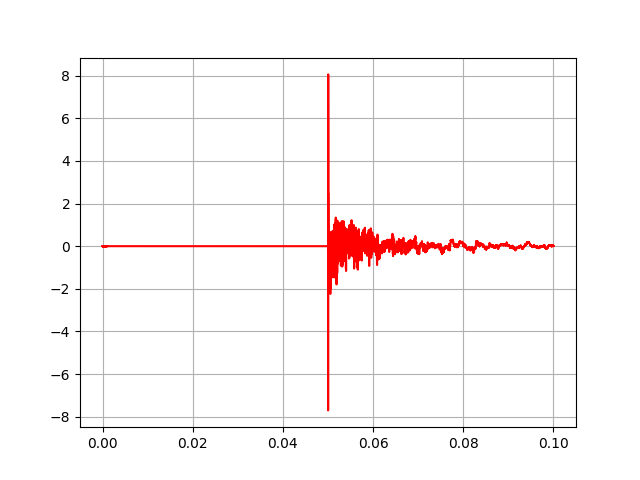

In [462]:
plt.close()
l = 5
plt.plot(ex_data[l][:,0], ex_data[l][:,1], label='P - 1', c = 'r')
plt.show()

In [463]:
ex_cut_data = []
for i in range(len(ex_data)):
    
    threshold = 0.1

    x = np.where(abs(ex_data[i][:,1])>threshold)[0][0]
    y = np.where(abs(ex_data[i][:,2])>threshold)[0][0]
    z = np.where(abs(ex_data[i][:,3])>threshold)[0][0]
    p = np.where(abs(ex_data[i][:,4])>threshold)[0][0]

    start = min(x,y,z,p)
    end = start+200

    d = np.empty_like(ex_data[i][start:end,:])

    d[:,0] = ex_data[i][start:end, 0]
    d[:,1] = (-1)*ex_data[i][start:end, 1]
    d[:,2] = (-1)*ex_data[i][start:end, 2]
    d[:,3] = (-1)*ex_data[i][start:end, 4]
    d[:,4] = (-1)*ex_data[i][start:end, 3]

    ex_cut_data.append(d)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
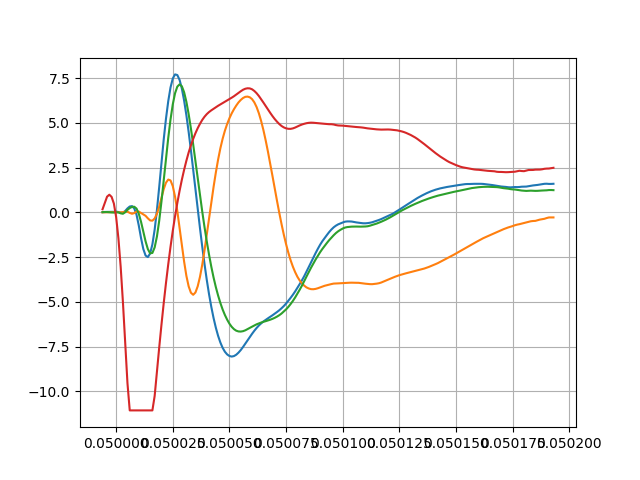

In [464]:
plt.close()
l = 5
plt.plot(ex_cut_data[l][:,0], ex_cut_data[l][:,1], label='P - 1')
plt.plot(ex_cut_data[l][:,0], ex_cut_data[l][:,2], label='P - 2')
plt.plot(ex_cut_data[l][:,0], ex_cut_data[l][:,3], label='P - 3')
plt.plot(ex_cut_data[l][:,0], ex_cut_data[l][:,4], label='P - 4')
plt.show()

Normalize and Resample experimental data

In [465]:
# create variables for normalized data
ex_norm = np.zeros_like(np.asarray(ex_cut_data))

for i in range (0, len(ex_cut_data)):
    for j in range (1, 5):
        ex_norm[i][:,j] = minmax_scale(ex_cut_data[i][:,j])

In [466]:
ex_resample = []

# create a dataframe from the normalized data
for i in range (0, len(ex_norm)):
    ex_resample.append(pd.DataFrame(ex_norm[i], columns = ['time', '1', '2', '3', '4']))
    # drop the time column
    ex_resample[i] = ex_resample[i].drop(columns = ['time'])

size = 100

for i in range (0, len(ex_resample)):
    ex_resample[i] = resample(ex_resample[i], size)

np.asarray(ex_resample).shape

(18, 100, 4)

##### Parse, Cut, Normalize, and Resample the experimental validation data

In [467]:
# Initialize lists for training and validation
ex_val_data = []; ex_val_labels = []

#------------------------------------------------------------------------------

for subdir, dirs, files in os.walk(rootdir):
    
    if Ex_Validation.lower() in subdir.lower():
        for file in files:
            if file.endswith('.txt'):
                
                with open(os.path.join(subdir, file), 'r') as f:
                    # print(file.split('_')[2], file.split('_')[3], file.split('_')[5][:3])
                    lbl = [file.split('_')[2], file.split('_')[3], file.split('_')[5][:3]]
                    lb = np.asarray(lbl, dtype=float)

                    x = pd.read_csv(os.path.join(subdir, file), delimiter='\t', decimal=',', skiprows=8, header=None)
                    x = np.asarray(x, dtype=float)
                    ex_val_data.append(x)
                    ex_val_labels.append(lb)


ex_val_trails = np.asarray(ex_val_labels)[:,2]
ex_val_labels = np.delete(ex_val_labels, 2, 1)

In [468]:
# ex_val_cut_data=[]
# for i in range(0,len(ex_val_data)):
#     data=ex_data[i][:,0]
    
#     start_time = 0.04996
#     end_time = 0.05016
#     start=np.where(data==(start_time))
#     end = np.where(data==(end_time))
    
#     d = np.zeros(((start[0][0]+200-start[0][0]),5))

#     d[:,0]=ex_val_data[i][start[0][0]:start[0][0]+200,0]
#     d[:,1]=ex_val_data[i][start[0][0]:start[0][0]+200,1]
#     d[:,2]=ex_val_data[i][start[0][0]:start[0][0]+200,2]
#     d[:,3]=ex_val_data[i][start[0][0]:start[0][0]+200,4]
#     d[:,4]=ex_val_data[i][start[0][0]:start[0][0]+200,3]
    
#     ex_val_cut_data.append(d)
#----------------------------------------------------------------------------------------


ex_val_cut_data = []
for i in range(len(ex_val_data)):
    
    threshold = 0.1

    x = np.where(abs(ex_val_data[i][:,1])>threshold)[0][0]
    y = np.where(abs(ex_val_data[i][:,2])>threshold)[0][0]
    z = np.where(abs(ex_val_data[i][:,3])>threshold)[0][0]
    p = np.where(abs(ex_val_data[i][:,4])>threshold)[0][0]

    start = min(x,y,z,p)
    end = start+180

    d = np.empty_like(ex_val_data[i][start:end,:])

    d[:,0] = ex_val_data[i][start:end, 0]
    d[:,1] = (-1)*ex_val_data[i][start:end, 1]
    d[:,2] = (-1)*ex_val_data[i][start:end, 2]
    d[:,3] = (-1)*ex_val_data[i][start:end, 4]
    d[:,4] = (-1)*ex_val_data[i][start:end, 3]

    ex_val_cut_data.append(d)

Normalize and Resample experimental validation data

In [469]:
# create variables for normalized data
ex_val_norm = np.zeros_like(np.asarray(ex_val_cut_data)); ex_val_norm_labels = np.zeros_like(np.asarray(ex_val_cut_data))

for i in range (0, len(ex_val_cut_data)):
    for j in range (1, 5):
        ex_val_norm[i][:,j] = minmax_scale(ex_val_cut_data[i][:,j])

scalar = MinMaxScaler()
ex_val_norm_labels = scalar.fit_transform(ex_val_labels)

In [470]:
ex_val_resample = []

# create a dataframe from the normalized data
for i in range (0, len(ex_val_norm)):
    ex_val_resample.append(pd.DataFrame(ex_val_norm[i], columns = ['time', '1', '2', '3', '4']))
    # drop the time column
    ex_val_resample[i] = ex_val_resample[i].drop(columns = ['time'])

size = 100

for i in range (0, len(ex_val_resample)):
    ex_val_resample[i] = resample(ex_val_resample[i], size)

np.asarray(ex_val_resample).shape

(24, 100, 4)

#### Augmentation

##### Variable initialization

In [471]:
## -----------------------------------------------------------------------------
#Assuming P1 on top and counter clockwise order
## -----------------------------------------------------------------------------


# Variables for the augmented data
training_tl = np.zeros_like(np.asarray(training_tr)); training_tl_labels = np.zeros_like(np.asarray(training_tr_labels))
training_bl = np.zeros_like(np.asarray(training_tr)); training_bl_labels = np.zeros_like(np.asarray(training_tr_labels))
training_br = np.zeros_like(np.asarray(training_tr)); training_br_labels = np.zeros_like(np.asarray(training_tr_labels))

##### Top-Left

In [472]:
for i in range (0, len(training_tr)):
        training_tl[i][:,0] = training_tr[i][:,0]
        training_tl[i][:,1] = training_tr[i][:,1]
        training_tl[i][:,2] = training_tr[i][:,4]
        training_tl[i][:,3] = training_tr[i][:,3]
        training_tl[i][:,4] = training_tr[i][:,2]

for i in range (0, len(training_tl_labels)):
    training_tl_labels[i][0] = 500 - training_tr_labels[i][0]
    training_tl_labels[i][1] = training_tr_labels[i][1]

##### Bottom-Left

In [473]:
for i in range (0, len(training_bl)):
    training_bl[i][:,0] = training_tl[i][:,0]
    training_bl[i][:,1] = training_tl[i][:,3]
    training_bl[i][:,2] = training_tl[i][:,2]
    training_bl[i][:,3] = training_tl[i][:,1]
    training_bl[i][:,4] = training_tl[i][:,4]

for i in range (0, len(training_bl_labels)):
    training_bl_labels[i][0] = 500. - training_tr_labels[i][0]
    training_bl_labels[i][1] = 500. - training_tr_labels[i][1]

##### Bottom-Right

In [474]:
for i in range (0, len(training_br)):
        training_br[i][:,0] = training_bl[i][:,0]
        training_br[i][:,1] = training_bl[i][:,1]
        training_br[i][:,2] = training_bl[i][:,4]
        training_br[i][:,3] = training_bl[i][:,3]
        training_br[i][:,4] = training_bl[i][:,2]

for i in range (0, len(training_br_labels)):
    training_br_labels[i][0] = training_tr_labels[i][0]
    training_br_labels[i][1] = 500 - training_tr_labels[i][1]

##### Delete overlapping data points

In [475]:
training_tl = np.delete(np.asarray(training_tl), np.where(np.asanyarray(training_tl_labels) == 250.)[0], axis = 0)
training_tl_labels = np.delete(np.asarray(training_tl_labels), np.where(np.asanyarray(training_tl_labels) == 250.)[0], axis = 0)

training_bl = np.delete(np.asarray(training_bl), 0, axis = 0)
training_bl_labels = np.delete(np.asarray(training_bl_labels), 0, axis = 0)

training_br = np.delete(np.asarray(training_br), np.where(np.asanyarray(training_br_labels) == 250.)[0], axis = 0)
training_br_labels = np.delete(np.asarray(training_br_labels), np.where(np.asanyarray(training_br_labels) == 250.)[0], axis = 0)

##### Makesure the augmentation is done on all quadrants

In [476]:
print(f'{np.asarray(training_tl).shape} \t{np.asarray(training_tr).shape} \n{np.asarray(training_bl).shape} \t{np.asarray(training_br).shape} \n{counter}')

(219, 20000, 5) 	(244, 20000, 5) 
(243, 20000, 5) 	(219, 20000, 5) 
0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
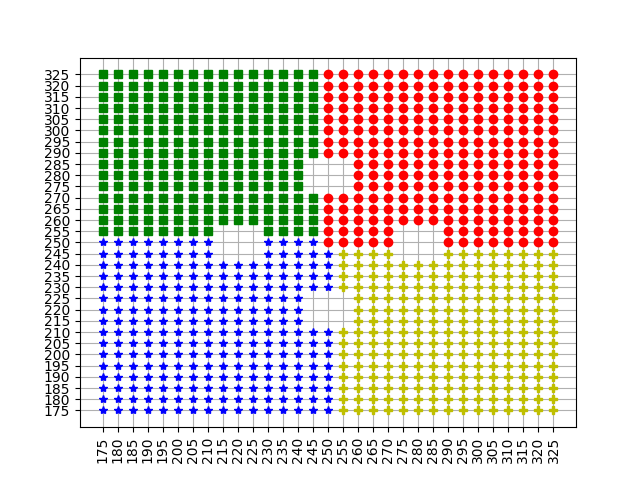

In [477]:
plt.close()
for i in range(0, len(training_tr_labels)):
    plt.plot(training_tr_labels[i][0], training_tr_labels[i][1], 'o', c = 'r')
for j in range (0, len(training_tl_labels)):
    plt.plot(training_tl_labels[j][0], training_tl_labels[j][1], 's', c = 'g')
    plt.plot(training_br_labels[j][0], training_br_labels[j][1], 'P', c = 'y')
for k in range (0, len(training_bl_labels)):
    plt.plot(training_bl_labels[k][0], training_bl_labels[k][1], '*', c = 'b')

plt.xticks(np.arange(175, 330, 5), rotation = 'vertical')
plt.yticks(np.arange(175, 330, 5))
plt.show()

#### Concatenate, Cut, Normalize, Resample Training Data

##### Concatenate

In [478]:
training = np.concatenate((training_tr, training_tl, training_bl, training_br), axis = 0)
training_labels = np.concatenate((training_tr_labels, training_tl_labels, training_bl_labels, training_br_labels), axis = 0)

print(f'Shape of all training set: {training.shape} \nShape of all training labels: {training_labels.shape}')

Shape of all training set: (925, 20000, 5) 
Shape of all training labels: (925, 2)


##### check with the validation augmented data

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
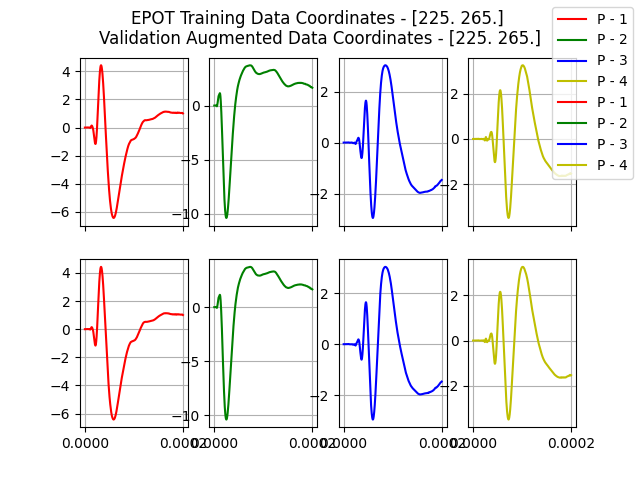

In [479]:
plt.close()
fig, axs = plt.subplots(2, 4, sharex=True)

val_c = 1 # Given validation folder has 4 data points. so use - (0, 1, 2, 3)

# find out the index of the validation set in the training data
x = []
for i in range (0, len(training_labels)):
    if (training_labels[i][0] == validation_aug_labels[val_c][0]) and (training_labels[i][1] == validation_aug_labels[val_c][1]):
        x.append(i)

# plot to compare the validation set with the training set
fig.suptitle(f'EPOT Training Data Coordinates - {training_labels[x[0]]} \nValidation Augmented Data Coordinates - {validation_aug_labels[val_c]}')

axs[0,0].plot(training[x[0]][:,0], training[x[0]][:,1], label='P - 1', c = 'r')
axs[0,1].plot(training[x[0]][:,0], training[x[0]][:,2], label='P - 2', c = 'g')
axs[0,2].plot(training[x[0]][:,0], training[x[0]][:,3], label='P - 3', c = 'b')
axs[0,3].plot(training[x[0]][:,0], training[x[0]][:,4], label='P - 4', c = 'y')

axs[1,0].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,1], label='P - 1', c = 'r')
axs[1,1].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,2], label='P - 2', c = 'g')
axs[1,2].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,3], label='P - 3', c = 'b')
axs[1,3].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,4], label='P - 4', c = 'y')

# check if the data is exactly the same
for i in range (1, 5):
    if np.all(training[x[0]][:,i] == validation_aug[val_c][:,i], axis = 0):
        print('Data is augmented correctly')

fig.legend()
plt.show()

In [480]:
diff = training[x[0]][:,1] - validation_aug[val_c][:,1]
diff

array([0.     , 0.     , 0.     , ..., 0.00011, 0.00012, 0.00012])

##### -- Check -- for outliers

In [481]:
'''
plt.close()
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

for i in range(len(training)):
    axs[0,0].plot(training[i][:,0], training[i][:,1], label='Training P-1')
    axs[0,1].plot(training[i][:,0], training[i][:,2], label='Training P-2')
    axs[1,0].plot(training[i][:,0], training[i][:,3], label='Training P-3')
    axs[1,1].plot(training[i][:,0], training[i][:,4], label='Training P-4')

plt.show()
'''

"\nplt.close()\nfig, axs = plt.subplots(2, 2, sharex=True, sharey=True)\n\nfor i in range(len(training)):\n    axs[0,0].plot(training[i][:,0], training[i][:,1], label='Training P-1')\n    axs[0,1].plot(training[i][:,0], training[i][:,2], label='Training P-2')\n    axs[1,0].plot(training[i][:,0], training[i][:,3], label='Training P-3')\n    axs[1,1].plot(training[i][:,0], training[i][:,4], label='Training P-4')\n\nplt.show()\n"

In [482]:
'''
%matplotlib inline
sns.set(rc={'figure.figsize':(30, 30)})

x = []; y = []; z = []

for i in range(len(training)):
    xi = training_labels[i][0]
    x.append(xi)
    yi = training_labels[i][1]
    y.append(yi)
    zi = pd.DataFrame(training[i][:,1]).max()[0]
    # zi = pd.DataFrame(training[i][:,2]).max()[0]
    # zi = pd.DataFrame(training[i][:,3]).max()[0]
    # zi = pd.DataFrame(training[i][:,4]).max()[0]

    z.append(zi)

df = pd.DataFrame({'x': x, 'y': y, 'z': z})

heatmap1_data = pd.pivot_table(df, values='z', index=['y'], columns='x')

ax = sns.heatmap(heatmap1_data, 
                square=True, 
                annot = True, 
                annot_kws={"fontsize": 10}, 
                fmt='.1f', 
                linewidths=0.1, 
                linecolor='gray',
                cbar_kws = dict(use_gridspec=False, location='right'))

ax.invert_yaxis()
'''

'\n%matplotlib inline\nsns.set(rc={\'figure.figsize\':(30, 30)})\n\nx = []; y = []; z = []\n\nfor i in range(len(training)):\n    xi = training_labels[i][0]\n    x.append(xi)\n    yi = training_labels[i][1]\n    y.append(yi)\n    zi = pd.DataFrame(training[i][:,1]).max()[0]\n    # zi = pd.DataFrame(training[i][:,2]).max()[0]\n    # zi = pd.DataFrame(training[i][:,3]).max()[0]\n    # zi = pd.DataFrame(training[i][:,4]).max()[0]\n\n    z.append(zi)\n\ndf = pd.DataFrame({\'x\': x, \'y\': y, \'z\': z})\n\nheatmap1_data = pd.pivot_table(df, values=\'z\', index=[\'y\'], columns=\'x\')\n\nax = sns.heatmap(heatmap1_data, \n                square=True, \n                annot = True, \n                annot_kws={"fontsize": 10}, \n                fmt=\'.1f\', \n                linewidths=0.1, \n                linecolor=\'gray\',\n                cbar_kws = dict(use_gridspec=False, location=\'right\'))\n\nax.invert_yaxis()\n'

Experimental Validation

In [483]:
'''
%matplotlib inline
sns.set(rc={'figure.figsize':(30, 30)})

x = []; y = []; z = []

for i in range(len(ex_val_data)):
    xi = ex_val_labels[i][0]
    x.append(xi)
    yi = ex_val_labels[i][1]
    y.append(yi)
    zi = pd.DataFrame(ex_val_data[i][:,1]).max()[0]
    # zi = pd.DataFrame(training[i][:,2]).max()[0]
    # zi = pd.DataFrame(training[i][:,3]).max()[0]
    # zi = pd.DataFrame(training[i][:,4]).max()[0]

    z.append(zi)

df = pd.DataFrame({'x': x, 'y': y, 'z': z})

heatmap1_data = pd.pivot_table(df, values='z', index=['y'], columns='x')

ax = sns.heatmap(heatmap1_data, 
                square=True, 
                annot = True, 
                annot_kws={"fontsize": 10}, 
                fmt='.1f', 
                linewidths=0.1, 
                linecolor='gray',
                cbar_kws = dict(use_gridspec=False, location='right'))

ax.invert_yaxis()
'''

'\n%matplotlib inline\nsns.set(rc={\'figure.figsize\':(30, 30)})\n\nx = []; y = []; z = []\n\nfor i in range(len(ex_val_data)):\n    xi = ex_val_labels[i][0]\n    x.append(xi)\n    yi = ex_val_labels[i][1]\n    y.append(yi)\n    zi = pd.DataFrame(ex_val_data[i][:,1]).max()[0]\n    # zi = pd.DataFrame(training[i][:,2]).max()[0]\n    # zi = pd.DataFrame(training[i][:,3]).max()[0]\n    # zi = pd.DataFrame(training[i][:,4]).max()[0]\n\n    z.append(zi)\n\ndf = pd.DataFrame({\'x\': x, \'y\': y, \'z\': z})\n\nheatmap1_data = pd.pivot_table(df, values=\'z\', index=[\'y\'], columns=\'x\')\n\nax = sns.heatmap(heatmap1_data, \n                square=True, \n                annot = True, \n                annot_kws={"fontsize": 10}, \n                fmt=\'.1f\', \n                linewidths=0.1, \n                linecolor=\'gray\',\n                cbar_kws = dict(use_gridspec=False, location=\'right\'))\n\nax.invert_yaxis()\n'

##### Cutting Training Data

In [484]:
train_cut = []
for i in range(len(training)):
    
    threshold = 0.1

    x = np.where(abs(training[i][:,1])>threshold)[0][0]
    y = np.where(abs(training[i][:,2])>threshold)[0][0]
    z = np.where(abs(training[i][:,3])>threshold)[0][0]
    p = np.where(abs(training[i][:,4])>threshold)[0][0]

    start = min(x,y,z,p)

    d = np.empty_like(training[i][start:,:])

    d[:,0] = training[i][start:, 0]
    d[:,1] = training[i][start:, 1]
    d[:,2] = training[i][start:, 2]
    d[:,3] = training[i][start:, 3]
    d[:,4] = training[i][start:, 4]

    train_cut.append(d)

##### Normalize Training Data

In [485]:
# maxim = []
# minim = []
# for i in range (len(train_cut)):
#     for j in range (1,5):
#         p = train_cut[i][:,j].max()
#         q = train_cut[i][:,j].min()

#         maxim.append(p)
#         minim.append(q)
# # print(np.asarray(maxim).max(),np.asarray(minim).min())

# create variables for normalized data
# train_norm = np.zeros_like(np.array(train_cut)) 
train_norm = []
train_norm_labels = np.zeros_like(np.asarray(training_labels))

for i in range (0, len(train_cut)):
    
    n = np.zeros_like(train_cut[i])
    n[:,1] = minmax_scale(train_cut[i][:,1])
    n[:,2] = minmax_scale(train_cut[i][:,2])
    n[:,3] = minmax_scale(train_cut[i][:,3])
    n[:,4] = minmax_scale(train_cut[i][:,4])
    
    train_norm.append(n)

    
scalar = MinMaxScaler()
train_norm_labels = scalar.fit_transform(training_labels)

In [486]:
maxim = []
minim = []
for i in range (len(train_norm)):
    for j in range (1,5):
        p = train_norm[i][:,j].max()
        q = train_norm[i][:,j].min()

        maxim.append(p)
        minim.append(q)
print(np.asarray(maxim).max(),np.asarray(minim).min())

1.0000000000000002 0.0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
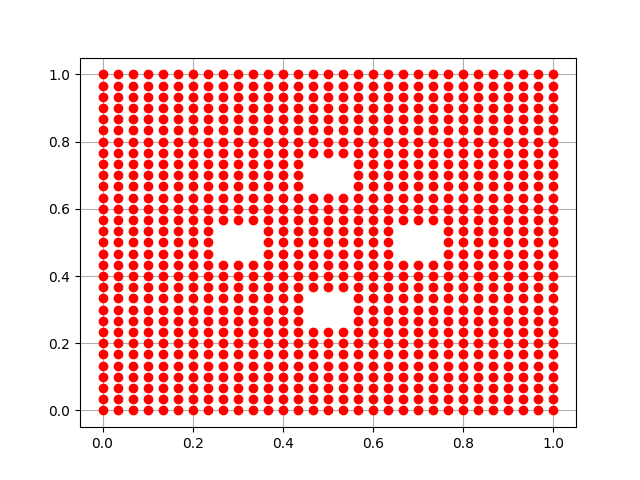

In [487]:
plt.close()
plt.plot(train_norm_labels[:,0], train_norm_labels[:,1], 'o', c = 'r', label = 'Normalized Training Data Labels')
plt.legend(loc='lower center', bbox_to_anchor=(1, -0.5))
plt.show()

##### Resample Training Data

In [488]:
train_resample = []

# create a dataframe from the normalized data
for i in range (0, len(training)):
    train_resample.append(pd.DataFrame(train_norm[i], columns = ['time', '1', '2', '3', '4']))
    # drop the time column
    train_resample[i] = train_resample[i].drop(columns = ['time'])

size = 100

for i in range (0, len(training)):
    train_resample[i] = resample(train_resample[i], size)

np.asarray(train_resample).shape

(925, 100, 4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
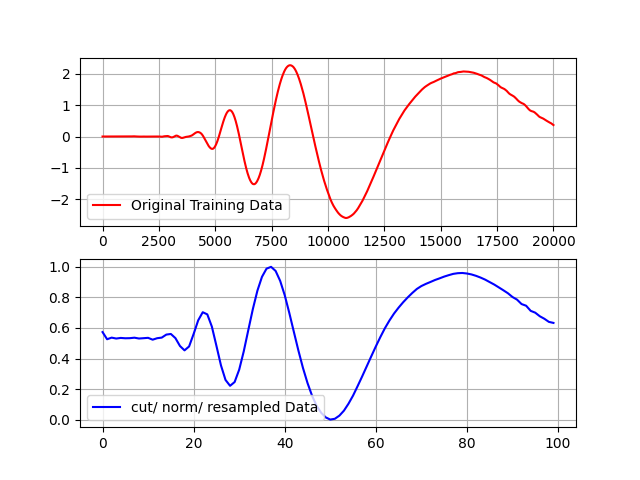

In [489]:
plt.close()
fig, axs = plt.subplots(2, 1)

axs[0].plot(training[10][:,2], c = 'r', label = 'Original Training Data')
axs[1].plot(train_resample[10][:,1], c = 'b', label = 'cut/ norm/ resampled Data')

axs[0].legend(loc='lower left')
axs[1].legend(loc='lower left')
plt.show()

#### Compare Experimental, Experimental-Validation and Training Data

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
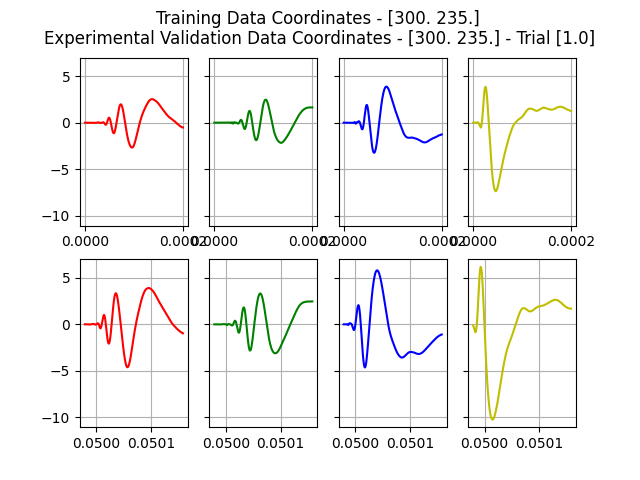

In [490]:
plt.close()
fig, axs = plt.subplots(2, 4, sharey=True)

ex_val_c = 20 # Given validation folder has 24 data points. so use - (0, 1, .... , 23)

# find out the index of the validation set in the training data
x = []
for i in range (0, len(training_labels)):
    if (training_labels[i][0] == ex_val_labels[ex_val_c][0]) and (training_labels[i][1] == ex_val_labels[ex_val_c][1]):
        x.append(i)

# plot to compare the validation set with the training set
fig.suptitle(f'Training Data Coordinates - {training_labels[x[0]]} \nExperimental Validation Data Coordinates - {ex_val_labels[ex_val_c]} - Trial [{ex_val_trails[ex_val_c]}]')

axs[0,0].plot(training[x[0]][:,0], training[x[0]][:,1], label='P - 1', c = 'r')
axs[0,1].plot(training[x[0]][:,0], training[x[0]][:,2], label='P - 2', c = 'g')
axs[0,2].plot(training[x[0]][:,0], training[x[0]][:,3], label='P - 3', c = 'b')
axs[0,3].plot(training[x[0]][:,0], training[x[0]][:,4], label='P - 4', c = 'y')

axs[1,0].plot(ex_val_cut_data[ex_val_c][:,0], ex_val_cut_data[ex_val_c][:,1], label='P - 1', c = 'r')
axs[1,1].plot(ex_val_cut_data[ex_val_c][:,0], ex_val_cut_data[ex_val_c][:,2], label='P - 2', c = 'g')
axs[1,2].plot(ex_val_cut_data[ex_val_c][:,0], ex_val_cut_data[ex_val_c][:,3], label='P - 3', c = 'b')
axs[1,3].plot(ex_val_cut_data[ex_val_c][:,0], ex_val_cut_data[ex_val_c][:,4], label='P - 4', c = 'y')

# fig.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
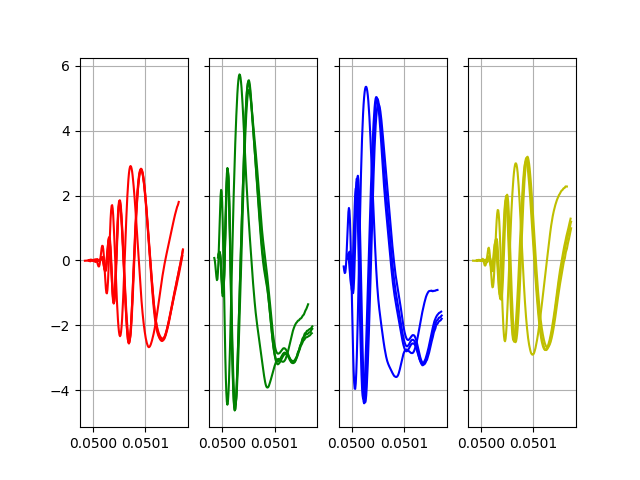

In [491]:
plt.close()
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)

for i in range(4):
    axs[0].plot(ex_val_cut_data[i][:,0], ex_val_cut_data[i][:,1], c = 'r', label = 'Exp Val Data - P-1')
    axs[1].plot(ex_val_cut_data[i][:,0], ex_val_cut_data[i][:,2], c = 'g', label = 'Exp Val Data - P-2')
    axs[2].plot(ex_val_cut_data[i][:,0], ex_val_cut_data[i][:,3], c = 'b', label = 'Exp Val Data - P-3')
    axs[3].plot(ex_val_cut_data[i][:,0], ex_val_cut_data[i][:,4], c = 'y', label = 'Exp Val Data - P-4')

plt.show()

#### Export data to pickle

In [492]:
# with open('training_data.pickle', 'wb') as f:
#     pickle.dump(training, f)

# with open('train_resample.pickle', 'wb') as f:
#     pickle.dump(train_resample, f)
# with open('train_norm_labels.pickle', 'wb') as f:
#     pickle.dump(train_norm_labels, f)

# with open('training_labels.pickle', 'wb') as f:
#     pickle.dump(training_labels, f)

# with open('exp_validation_data.pickle', 'wb') as f:
#     pickle.dump(ex_val_data, f)
# with open('exp_validation_labels.pickle', 'wb') as f:
#     pickle.dump(ex_val_labels, f)
# with open('exp_validation_trails.pickle', 'wb') as f:
#     pickle.dump(ex_val_trails, f)


# with open('exp_val_resample.pickle', 'wb') as f:
#     pickle.dump(ex_val_resample, f)
# with open('exp_val_norm_labels.pickle', 'wb') as f:
#     pickle.dump(ex_val_norm_labels, f)

# with open('ex_resample.pickle', 'wb') as f:
#     pickle.dump(ex_resample, f)

#### AI Model

##### Split the data into training and testing sets

In [493]:
# Extract the data from the pickle files
'''
with open('train_resample.pickle', 'rb') as f:
    train_resample = pickle.load(f)
with open('train_norm_labels.pickle', 'rb') as f:
    train_norm_labels = pickle.load(f)
'''

X = np.asarray(train_resample)
y = np.asarray(train_norm_labels)

# create split data from the normalized data
size = 0.2
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=size)
print(f'Length of training data - {len(x_train)} length of labels - {len(y_train)} \nLength of test data - {len(x_test)} length of labels - {len(y_test)}')

Length of training data - 740 length of labels - 740 
Length of test data - 185 length of labels - 185


##### TensorBoard

In [494]:
# %tensorboard --logdir=logs/

##### Model Training and Tuning

DNN Tuning

In [495]:
'''
log_files = f'DNN_log.{int(time.time())}'
tuner_logs= f'tunelog/DNN_tuner_log.{int(time.time())}'

tensorboard = TensorBoard(log_dir=f'logs/{log_files}', 
                          histogram_freq=1, 
                          write_graph=True,
                          write_grads=True)


def dnnModel(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(100,4)))
    model.add(Dense(units=hp.Int('layer_1_nodes', 
                    min_value=32, max_value=512, step=32), 
                    activation=hp.Choice("activation_1", ["relu", "sigmoid", "tanh"])))
    
    for i in range(hp.Int('n_layers', min_value=0, max_value=4, step=1)):
        model.add(Dense(units=hp.Int(f'layer_{i+1}_nodes', min_value=32, max_value=512, step=32), activation=hp.Choice(f"activation_{i+1}", ["relu", "sigmoid", "tanh"])))
    
    model.add(Dense(units=2, activation=hp.Choice("activation_out", ['sigmoid', 'linear']))) # output layer

    model.summary()

    # Compile model
    # lr = hp.Float("lr", min_value=1e-4, max_value=1e-2)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    sgd = tf.keras.optimizers.SGD(learning_rate=0.0001)

    model.compile(loss = hp.Choice('loss', ['mae']),
                optimizer = hp.Choice('optimizer', ['Adam', 'RMSprop']), 
                metrics=['Accuracy'])
    
    return model

# Hyperparameter tuning
tuner = RandomSearch(dnnModel,
                    objective='val_Accuracy',
                    max_trials=50,
                    executions_per_trial=2,
                    directory=tuner_logs,
                    project_name='DNN_tuning')

tuner.search(x=x_train,
            y=y_train,
            epochs=60,
            batch_size=32,
            validation_data=(x_test, y_test),
            callbacks=[tensorboard])
            '''

'\nlog_files = f\'DNN_log.{int(time.time())}\'\ntuner_logs= f\'tunelog/DNN_tuner_log.{int(time.time())}\'\n\ntensorboard = TensorBoard(log_dir=f\'logs/{log_files}\', \n                          histogram_freq=1, \n                          write_graph=True,\n                          write_grads=True)\n\n\ndef dnnModel(hp):\n    model = Sequential()\n    model.add(Flatten(input_shape=(100,4)))\n    model.add(Dense(units=hp.Int(\'layer_1_nodes\', \n                    min_value=32, max_value=512, step=32), \n                    activation=hp.Choice("activation_1", ["relu", "sigmoid", "tanh"])))\n    \n    for i in range(hp.Int(\'n_layers\', min_value=0, max_value=4, step=1)):\n        model.add(Dense(units=hp.Int(f\'layer_{i+1}_nodes\', min_value=32, max_value=512, step=32), activation=hp.Choice(f"activation_{i+1}", ["relu", "sigmoid", "tanh"])))\n    \n    model.add(Dense(units=2, activation=hp.Choice("activation_out", [\'sigmoid\', \'linear\']))) # output layer\n\n    model.summary()\

In [496]:
# bestModels = tuner.get_best_models(num_models=2)

In [497]:
# Save the keras model
# model.save(f'model/complete_tunedModel_97perAcc.{int(time.time())}.h5')

CNN Tuning

In [498]:
'''
log_files = f'CNN_log.{int(time.time())}'
tuner_logs= f'tunelog/CNN_tuner_log.{int(time.time())}'

tensorboard = TensorBoard(log_dir=f'logs/{log_files}', 
                          histogram_freq=1, 
                          write_graph=True,
                          write_grads=True)

def cnnModel(hp):
    model = Sequential()

    model.add(Conv1D(filters=hp.Int('conv_1_filter', min_value=32, max_value=512, step=32), 
                     kernel_size=hp.Int('Kernal_1', min_value=2, max_value=5, step=1), 
                     strides=hp.Int('stride_1', min_value=1, max_value=5, step=1),
                     activation=hp.Choice("activation_1", ["relu", "sigmoid"]), 
                     input_shape=(100,4)))
    
    model.add(MaxPooling1D(pool_size=hp.Int('pool_1', min_value=2, max_value=5, step=1))),

    for i in range(hp.Int('n_layers', min_value=0, max_value=4, step=1)):
        model.add(Conv1D(filters=hp.Int(f'conv_{i+1}_filter', min_value=32, max_value=512, step=32), 
                         kernel_size=hp.Int(f'Kernal_{i+1}', min_value=2, max_value=5, step=1), 
                         strides=hp.Int(f'stride_{i+1}', min_value=1, max_value=5, step=1),
                         activation=hp.Choice(f"activation_{i+1}", ["relu", "sigmoid"])))
        model.add(MaxPooling1D(pool_size=hp.Int(f'pool_{i+1}', min_value=2, max_value=5, step=1)))

    model.add(Flatten())


    model.add(Dense(units=hp.Int('FC_layer_1_nodes',
                    min_value=32, max_value=512, step=32),
                    activation=hp.Choice("FC_activation_1", ["relu", "sigmoid"])))
    
    model.add(Dense(units=hp.Int('FC_layer_2_nodes',
                    min_value=32, max_value=512, step=32),
                    activation=hp.Choice("FC_activation_2", ["relu", "sigmoid"])))

    model.add(Dense(units=2, activation=hp.Choice("activation_out", ['sigmoid', 'linear']))) # output layer

    model.summary()

    # Compile model
    # lr = hp.Float("lr", min_value=1e-4, max_value=1e-2)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    sgd = tf.keras.optimizers.SGD(learning_rate=0.0001)

    model.compile(loss = hp.Choice('loss', ['mse', 'mae']),
                optimizer = hp.Choice('optimizer', ['Adam', 'RMSprop']), 
                metrics=['Accuracy'])

    return model

# Hyperparameter tuning
tuner = RandomSearch(cnnModel,
                    objective='val_Accuracy',
                    max_trials=560,
                    executions_per_trial=3,
                    directory=tuner_logs,
                    project_name='CNN_tuning')

tuner.search(x=x_train,
            y=y_train,
            epochs=60,
            batch_size=32,
            validation_data=(x_test, y_test),
            callbacks=[tensorboard])
'''

'\nlog_files = f\'CNN_log.{int(time.time())}\'\ntuner_logs= f\'tunelog/CNN_tuner_log.{int(time.time())}\'\n\ntensorboard = TensorBoard(log_dir=f\'logs/{log_files}\', \n                          histogram_freq=1, \n                          write_graph=True,\n                          write_grads=True)\n\ndef cnnModel(hp):\n    model = Sequential()\n\n    model.add(Conv1D(filters=hp.Int(\'conv_1_filter\', min_value=32, max_value=512, step=32), \n                     kernel_size=hp.Int(\'Kernal_1\', min_value=2, max_value=5, step=1), \n                     strides=hp.Int(\'stride_1\', min_value=1, max_value=5, step=1),\n                     activation=hp.Choice("activation_1", ["relu", "sigmoid"]), \n                     input_shape=(100,4)))\n    \n    model.add(MaxPooling1D(pool_size=hp.Int(\'pool_1\', min_value=2, max_value=5, step=1))),\n\n    for i in range(hp.Int(\'n_layers\', min_value=0, max_value=4, step=1)):\n        model.add(Conv1D(filters=hp.Int(f\'conv_{i+1}_filter\', min_v

In [499]:
# bestModels = tuner.get_best_models(num_models=2)

#### DNN Model

In [549]:
model = Sequential()
model.add(Flatten(input_shape=(100,4)))

model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=96, activation='relu'))
model.add(Dense(units=12, activation='relu'))

model.add(Dense(units=2, activation='linear'))

model.summary()

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss = 'mse', optimizer = 'Adam', metrics=['Accuracy'])

# Fit the model
history = model.fit(x_train, y_train, epochs=50, verbose=1, batch_size=32, validation_data=(x_test, y_test))

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_33 (Flatten)        (None, 400)               0         
                                                                 
 dense_123 (Dense)           (None, 512)               205312    
                                                                 
 dense_124 (Dense)           (None, 256)               131328    
                                                                 
 dense_125 (Dense)           (None, 256)               65792     
                                                                 
 dense_126 (Dense)           (None, 96)                24672     
                                                                 
 dense_127 (Dense)           (None, 12)                1164      
                                                                 
 dense_128 (Dense)           (None, 2)               

In [501]:
# model.save(f'model/DNN_val_acc_97perAcc.{int(time.time())}.h5')

In [550]:
mean_squared_error(scalar.inverse_transform(y_test), scalar.inverse_transform(model.predict(x_test)), squared=True)

33.737610316267094

In [503]:
# mean_squared_error((ex_val_labels), scalar.inverse_transform(model.predict(ex_val_resample)), squared=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
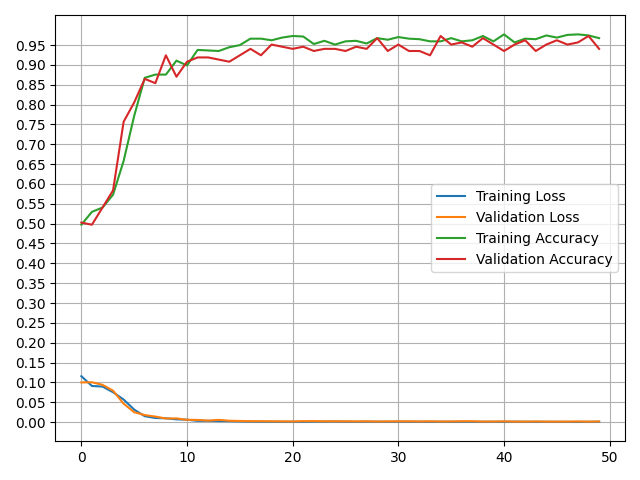

In [551]:
plt.close()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['Accuracy'], label='Training Accuracy')
plt.plot(history.history['val_Accuracy'], label='Validation Accuracy')

plt.yticks(np.arange(0, 1, 0.05))

plt.tight_layout()
plt.legend()
plt.show()

#### FINAL - Tuned - CNN

In [530]:
Alex4=Sequential()

Alex4.add(Conv1D(filters=96, kernel_size=5, strides=4, activation='relu', input_shape=(100,4), padding='same'))
Alex4.add(MaxPooling1D(pool_size=3, strides= 2, padding='valid'))
Alex4.add(Dropout(0.3))

Alex4.add(Conv1D(filters=256, strides=1, kernel_size=5, activation='relu', padding='same'))
Alex4.add(MaxPooling1D(pool_size=3, strides=2, padding='valid'))

Alex4.add(Conv1D(filters=384, strides=1, kernel_size=3, activation='relu', padding='same'))
Alex4.add(Dropout(0.4))

Alex4.add(Conv1D(filters=256, strides=1, kernel_size=3, activation='relu', padding='same'))

Alex4.add(Conv1D(filters=256, strides=1, kernel_size=3, activation='relu', padding='same'))
Alex4.add(MaxPooling1D(pool_size=3, strides=2, padding='valid'))

# Fully Connected Layers
Alex4.add(Flatten())
Alex4.add(Dense(units=128, activation='relu',use_bias='False'))
Alex4.add(Dense(units=64, activation='relu',use_bias='False'))
Alex4.add(Dense(units=2, activation='linear',use_bias='False'))
Alex4.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

Alex4.compile(loss = 'mse', optimizer = 'Adam', metrics=['Accuracy'])

# Fit the cnn_model
Alex_history = Alex4.fit(x_train, y_train, epochs=90, verbose=1, batch_size=32, validation_data=(x_test, y_test))

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_115 (Conv1D)         (None, 25, 96)            2016      
                                                                 
 max_pooling1d_69 (MaxPoolin  (None, 12, 96)           0         
 g1D)                                                            
                                                                 
 dropout_46 (Dropout)        (None, 12, 96)            0         
                                                                 
 conv1d_116 (Conv1D)         (None, 12, 256)           123136    
                                                                 
 max_pooling1d_70 (MaxPoolin  (None, 5, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_117 (Conv1D)         (None, 5, 384)          

In [531]:
mean_squared_error(scalar.inverse_transform(y_test), scalar.inverse_transform(Alex4.predict(x_test)), squared=True)
# mean_absolute_error(scalar.inverse_transform(y_test), scalar.inverse_transform(Alex4.predict(x_test)))

11.730040729321498

In [509]:
# Alex4.save(f'model/FINAL_CNN_val_acc_97_16_MSE.{int(time.time())}.h5')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
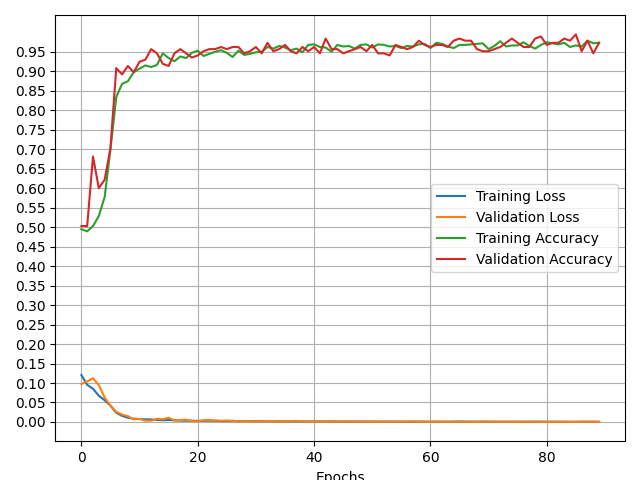

In [527]:
plt.close()
plt.plot(Alex_history.history['loss'], label='Training Loss')
plt.plot(Alex_history.history['val_loss'], label='Validation Loss')
plt.plot(Alex_history.history['Accuracy'], label='Training Accuracy')
plt.plot(Alex_history.history['val_Accuracy'], label='Validation Accuracy')

plt.yticks(np.arange(0, 1, 0.05))

plt.tight_layout()
plt.xlabel('Epochs')
plt.legend()
plt.show()

#### Predict experimental data validation

In [ ]:
# model = tf.keras.models.load_model('model/tunedModel_98perAcc.1640573960.h5')
# model = tf.keras.models.load_model('Alex3.h5')
# model = tf.keras.models.load_model('model/CNN_val_acc_96_48_MSEperAcc.1642513870.h5')
# model.summary()

In [528]:
y_pred = Alex4.predict(np.asarray(ex_val_resample))
y_abs = ex_val_labels

y_pred = scalar.inverse_transform(np.asarray(y_pred))
diff = y_abs-y_pred
for i in range(len(y_pred)):
    print(f'Absolute Trial {ex_val_trails[i]}- {y_abs[i]} Predicted - {y_pred[i]} \tDifference - {y_abs[i] - y_pred[i]}')

Absolute Trial 1.0- [205. 200.] Predicted - [206.9755  208.31996] 	Difference - [-1.97549438 -8.31996155]
Absolute Trial 2.0- [205. 200.] Predicted - [206.49991 207.76308] 	Difference - [-1.49990845 -7.76307678]
Absolute Trial 3.0- [205. 200.] Predicted - [208.95625 208.12384] 	Difference - [-3.95625305 -8.12384033]
Absolute Trial 4.0- [205. 200.] Predicted - [205.45058 206.93883] 	Difference - [-0.45057678 -6.93882751]
Absolute Trial 1.0- [225. 210.] Predicted - [224.11612 207.94052] 	Difference - [0.88388062 2.05947876]
Absolute Trial 2.0- [225. 210.] Predicted - [222.59735 208.40015] 	Difference - [2.40264893 1.59985352]
Absolute Trial 3.0- [225. 210.] Predicted - [222.83698 208.85555] 	Difference - [2.1630249  1.14445496]
Absolute Trial 4.0- [225. 210.] Predicted - [223.60371 210.06804] 	Difference - [ 1.39628601 -0.06803894]
Absolute Trial 1.0- [230. 245.] Predicted - [230.48744 241.52927] 	Difference - [-0.48744202  3.47073364]
Absolute Trial 2.0- [230. 245.] Predicted - [229.120

In [529]:
mean_squared_error(y_abs, y_pred, squared=True)
# mean_absolute_error(y_abs, y_pred)

22.130158842201734

#### Experimental Group - 7 Data

In [519]:
y_pred_g7 = Alex4.predict(np.asarray(ex_resample))
y_pred_g7 = scalar.inverse_transform(y_pred_g7)
y_pred_g7

array([[256.37027, 240.89412],
       [240.10654, 231.1068 ],
       [244.48915, 253.42422],
       [258.66077, 219.3922 ],
       [240.26274, 250.04279],
       [265.47412, 249.16577],
       [235.97969, 293.28687],
       [230.98907, 227.29135],
       [260.4287 , 290.12485],
       [255.61246, 255.5696 ],
       [263.08124, 229.25546],
       [256.7316 , 245.838  ],
       [206.87952, 228.05023],
       [256.89395, 255.35712],
       [240.98085, 251.1976 ],
       [223.51427, 205.27109],
       [256.48572, 300.08252],
       [294.7004 , 271.0468 ]], dtype=float32)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
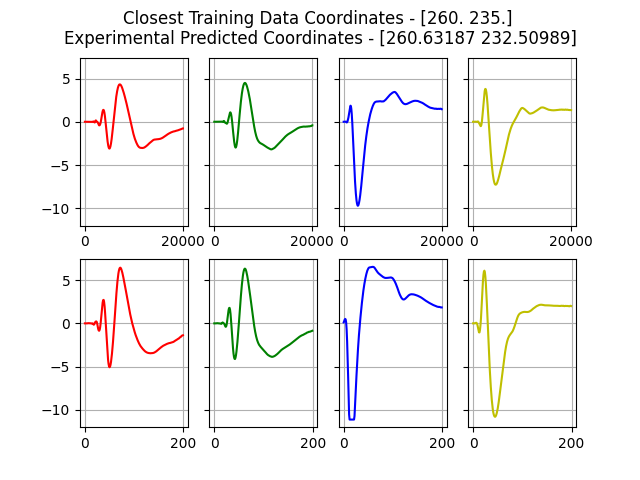

In [373]:
plt.close()
fig, axs = plt.subplots(2, 4, sharey=True)

ex_c = 10 # Given validation folder has 18 data points. so use - (0, 1, .... , 17)

# find out the index of the validation set in the training data
p = []

for i in range (len(y_pred_g7)):
    xi = np.where(training_labels[:,0] == min(training_labels[:,0], key=lambda x:abs(x-y_pred_g7[i][0])))[0]
    yi = np.where(training_labels[:,1] == min(training_labels[:,1], key=lambda x:abs(x-y_pred_g7[i][1])))[0]
    pi = np.intersect1d(xi, yi)[0]
    
    p.append(pi)

# plot to compare the validation set with the training set
fig.suptitle(f'Closest Training Data Coordinates - {training_labels[p[ex_c]]} \nExperimental Predicted Coordinates - {y_pred_g7[ex_c]}')

axs[0,0].plot(training[p[ex_c]][:,1], label='P - 1', c = 'r')
axs[0,1].plot(training[p[ex_c]][:,2], label='P - 2', c = 'g')
axs[0,2].plot(training[p[ex_c]][:,3], label='P - 3', c = 'b')
axs[0,3].plot(training[p[ex_c]][:,4], label='P - 4', c = 'y')

axs[1,0].plot(ex_cut_data[ex_c][:,1], label='P - 1', c = 'r')
axs[1,1].plot(ex_cut_data[ex_c][:,2], label='P - 2', c = 'g')
axs[1,2].plot(ex_cut_data[ex_c][:,3], label='P - 3', c = 'b')
axs[1,3].plot(ex_cut_data[ex_c][:,4], label='P - 4', c = 'y')

# fig.legend()
plt.show()

#### Old CNN Model

In [ ]:
# reg = tf.keras.regularizers.L2(0.01)

cnn_model = Sequential()
# create a CNN cnn_model
cnn_model.add(Conv1D(filters=224, kernel_size=3, activation='relu', input_shape=(100,4)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.25))
cnn_model.add(Conv1D(filters=384, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(filters=384, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))

cnn_model.add(Flatten())

cnn_model.add(Dense(units=32, activation='sigmoid'))
cnn_model.add(Dense(units=480, activation='relu'))
cnn_model.add(Dense(units=2, activation='linear'))
cnn_model.summary()
3
# Compile cnn_model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

cnn_model.compile(loss = 'mse', optimizer = 'RMSprop', metrics=['Accuracy'])

# Fit the cnn_model
cnn_history = cnn_model.fit(x_train, y_train, epochs=80, verbose=1, batch_size=32, validation_data=(x_test, y_test))

In [ ]:
plt.close()
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.plot(cnn_history.history['Accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_Accuracy'], label='Validation Accuracy')

plt.yticks(np.arange(0, 1, 0.05))

plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
mean_squared_error(scalar.inverse_transform(y_test), scalar.inverse_transform(cnn_model.predict(x_test)), squared=False)

In [ ]:
# cnn_save = cnn_model.save(f'model/cnn_model_98-7perAcc.{int(time.time())}.h5')

In [ ]:
# cnn_98 = tf.keras.models.load_model('CNN_98_1.h5')

#### SVR Model

In [398]:
X = train_resample
y = training_labels

# create split data from the normalized data
size = 0.2
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=size)
print(f'Length of training data - {len(x_train)} length of labels - {len(y_train)} \nLength of test data - {len(x_test)} and length of labels - {len(y_test)}')

x_train_flat = []
for i in range(len(x_train)):    
    x_dummy = np.asarray(x_train[i]).flatten()
    x_train_flat.append(x_dummy)
    
x_train_flat = np.asarray(x_train_flat)

x_test_flat = []
for i in range(len(x_test)):    
    x_dummy = np.asarray(x_test[i]).flatten()
    x_test_flat.append(x_dummy)
    
x_test_flat = np.asarray(x_test_flat)

print(np.asarray(x_train_flat).shape, np.asarray(y_train).shape)

Length of training data - 740 length of labels - 740 
Length of test data - 185 and length of labels - 185
(740, 400) (740, 2)


In [423]:
regr_multirf = MultiOutputRegressor(svm.SVR(kernel='rbf', C=1e5, gamma=0.03, epsilon=0.2, tol=1e-6))
regr_multirf.fit(x_train_flat, y_train)

y_pred = regr_multirf.predict(x_test_flat)
y_test-y_pred

array([[ 5.52618368e-01,  3.55831181e+00],
       [-5.64131665e+00, -4.07759596e+00],
       [-1.93175657e+00, -1.79896084e+00],
       [-1.87581995e-01,  4.48288319e+00],
       [ 7.81067143e-02, -2.24865524e+00],
       [ 6.17369832e+00,  6.02395807e+00],
       [ 2.05420882e+00,  2.43486467e+00],
       [-1.94303887e+00,  2.28780653e-01],
       [ 1.79090702e+00,  2.12581920e+00],
       [ 1.83730192e+00,  6.08216063e+00],
       [-1.98509002e+00,  2.07972507e-01],
       [ 2.50595095e+00, -1.28712426e+00],
       [ 2.31913091e+00,  6.97926807e-01],
       [-3.51902771e-01,  6.10402461e-01],
       [ 4.09351190e+00,  1.45618963e+00],
       [ 2.79072024e+00, -3.63819074e-01],
       [ 7.70483742e+00,  7.54446029e+00],
       [ 2.82802385e+00,  1.75901991e-02],
       [-5.04777539e-01, -2.49431455e+00],
       [ 4.02565382e+00, -2.51624558e+00],
       [-3.55067536e-01, -2.68948669e+00],
       [-9.43116718e-01, -1.55604421e+00],
       [ 4.50414736e-01,  1.11342869e+00],
       [ 9.

In [424]:
mean_squared_error(y_test, y_pred, squared=True)

17.43568549516219

In [425]:
y_pred_exp = regr_multirf.predict(exp_val_X_flat)

mean_squared_error(exp_val_y,y_pred_exp)

159.8406051028462

In [426]:
ex_X_flat = []
for i in range(len(ex_resample)):
    x_dummy = np.asarray(ex_resample[i]).flatten()
    ex_X_flat.append(x_dummy)

ex_X_flat = np.asarray(ex_X_flat)
ex_X_flat.shape

(18, 400)

In [427]:
y_pred_g7_knn = regr_multirf.predict(ex_X_flat)
y_pred_g7_knn

array([[250.06793316, 250.79507902],
       [231.97159639, 238.64112438],
       [249.19521029, 251.38178279],
       [257.78393812, 237.11054115],
       [244.15418163, 251.20548521],
       [250.35625136, 248.67475642],
       [239.3444404 , 289.24811953],
       [237.7952098 , 232.28723349],
       [260.3624297 , 289.3993173 ],
       [250.61274469, 247.78279764],
       [260.30830264, 238.38361307],
       [251.10926254, 252.26793372],
       [214.25157777, 237.19283252],
       [253.834616  , 247.23132388],
       [253.58760954, 246.16046159],
       [234.47037567, 212.35708741],
       [265.10354401, 299.15771129],
       [290.82617266, 268.88179454]])

#### KNN Model

In [368]:
X = train_resample
y = training_labels

exp_val_X = ex_val_resample
exp_val_y = ex_val_labels

print(np.asarray(X).shape, np.asarray(y).shape)

# create split data from the normalized data
size = 0.1
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=size)
print(f'Length of training data - {np.asarray(x_train).shape} length of labels - {np.asarray(y_train).shape} \nLength of test data - {np.asarray(x_test).shape} and length of labels - {np.asarray(y_test).shape}')

(925, 100, 4) (925, 2)
Length of training data - (832, 100, 4) length of labels - (832, 2) 
Length of test data - (93, 100, 4) and length of labels - (93, 2)


In [369]:
x_train_flat = []
for i in range(len(x_train)):    
    x_dummy = np.asarray(x_train[i]).flatten()
    x_train_flat.append(x_dummy)
    
x_train_flat = np.asarray(x_train_flat)

x_test_flat = []
for i in range(len(x_test)):    
    x_dummy = np.asarray(x_test[i]).flatten()
    x_test_flat.append(x_dummy)
    
x_test_flat = np.asarray(x_test_flat)

exp_val_X_flat = []
for i in range(len(exp_val_X)):
    x_dummy = np.asarray(exp_val_X[i]).flatten()
    exp_val_X_flat.append(x_dummy)

exp_val_X_flat = np.asarray(exp_val_X_flat)

print(np.asarray(x_train_flat).shape, np.asarray(y_train).shape)
print(x_test_flat.shape, y_test.shape)
print(exp_val_X_flat.shape, exp_val_y.shape)

(832, 400) (832, 2)
(93, 400) (93, 2)
(24, 400) (24, 2)


In [390]:
knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(x_train_flat, y_train)
y_pred = knn.predict(x_test_flat)
y_test-y_pred

array([[ 4.23630314e-01, -6.73259287e-01],
       [-3.82580389e+00, -2.30988027e+00],
       [ 8.88331937e-03, -1.13949006e+00],
       [-2.95442600e-01, -8.67268473e-01],
       [-3.96668897e-02, -1.14058566e+00],
       [-8.39556666e-01, -1.46350977e+00],
       [ 7.49592106e-01, -1.44533114e+00],
       [ 1.51673440e+00, -5.20156520e-01],
       [ 7.49408941e-01,  2.28583806e-01],
       [ 9.19688833e-01,  8.23756248e-01],
       [-1.46070717e-01,  8.74786935e-01],
       [-8.41920925e-01,  8.65380865e-01],
       [-1.75246639e+00,  2.60948270e+00],
       [ 8.07876690e-01,  2.58100736e-02],
       [ 1.16934207e+00,  1.43220098e-01],
       [ 1.30928404e+00, -8.65736951e-02],
       [-7.45389283e-01, -1.47883751e+00],
       [ 5.65824472e-01,  1.11126707e+00],
       [-5.99843339e-01,  7.76586740e-01],
       [-3.95211315e+00,  4.88048840e+00],
       [-1.36932997e+00, -3.73396009e-02],
       [ 5.48710632e-02, -8.12413033e-01],
       [ 3.15153050e-01,  8.02865154e-01],
       [ 6.

In [391]:
mean_squared_error(y_test, y_pred)

16.567667299812836

In [392]:
y_pred_exp = knn.predict(exp_val_X_flat)

mean_squared_error(exp_val_y,y_pred_exp)

31.592585861170946

In [395]:
ex_X_flat = []
for i in range(len(ex_resample)):
    x_dummy = np.asarray(ex_resample[i]).flatten()
    ex_X_flat.append(x_dummy)

ex_X_flat = np.asarray(ex_X_flat)
ex_X_flat.shape

(18, 400)

In [397]:
y_pred_g7_knn = knn.predict(ex_X_flat)
y_pred_g7_knn

array([[252.1540348 , 254.10530699],
       [237.15888271, 234.25082794],
       [242.138558  , 253.9317304 ],
       [261.21171867, 227.86267453],
       [241.58244176, 250.98204092],
       [262.15475429, 250.21337036],
       [231.18697074, 298.33953765],
       [230.45431173, 228.18011563],
       [263.86708951, 291.46385126],
       [254.79606447, 248.1341735 ],
       [260.11374453, 231.65221952],
       [247.25550314, 252.37074335],
       [202.21791446, 223.96026928],
       [257.51058208, 252.28363596],
       [248.48166672, 245.66359929],
       [221.87867369, 201.83897448],
       [260.48865137, 307.8461354 ],
       [294.16454132, 283.6093645 ]])

#### -- Check -- prediction for augmentation validation data

In [ ]:
c = []
checking1 = validation_aug[0][:,1:5]
checking1 = minmax_scale(checking1)
checking1 = resample(checking1, 100)

checking2 = validation_aug[1][:,1:5]
checking2 = minmax_scale(checking2)
checking2 = resample(checking2, 100)

checking3 = validation_aug[2][:,1:5]
checking3 = minmax_scale(checking3)
checking3 = resample(checking3, 100)

checking4 = validation_aug[3][:,1:5]
checking4 = minmax_scale(checking4)
checking4 = resample(checking4, 100)

c.append(checking1)
c.append(checking2)
c.append(checking3)
c.append(checking4)

'''
plt.close()
plt.title(f'Validation Data {validation_aug_labels[0]}')
plt.plot(checking1[:,0], label = 'P - 1')
plt.plot(checking1[:,1], label = 'P - 2')
plt.plot(checking1[:,2], label = 'P - 3')
plt.plot(checking1[:,3], label = 'P - 4')
plt.legend()
plt.show()
'''

In [ ]:
print(f'{validation_aug_labels[0]} \n{validation_aug_labels[1]} \n{validation_aug_labels[2]} \n{validation_aug_labels[3]}')

p = Alex4.predict(np.asarray(c))
p = scalar.inverse_transform(p)
print(p)

error = []
for i in range(0, len(p)):
    a = validation_aug_labels[i][0]-p[i][0]
    b = validation_aug_labels[i][1]-p[i][1]
    e = [a, b]
    error.append(e)

print(f'Difference between the actual and predicted coordinates: \n{np.asarray(error)}')